# Compare feasibility analysis

Compare feasibility QOIs from two campaigns.

In [2]:
import easyvvuq as uq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path

In [3]:
# Define study dirs here
study_names = ["max_net_elec", "min_rmajor"]
# study_names = ["screened", "screened_min_rmajor"]

print("Reading in campaign databases.")

study_dirs = [Path(study_name) for study_name in study_names]
samples_list = []
campaigns = []
# Find DB
for study_dir in study_dirs:
    db_count = 0
    for db_path in study_dir.glob("campaigns/*/campaign.db"):
        if db_count > 0:
            raise RuntimeError("More than one database in the campaigns dir")

        db_location = str(db_path.resolve())
        db_count += 1

    # /// prefix is required before absolute path
    db_location_prefixed = f"sqlite:///{db_location}"
    campaign = uq.Campaign(
        db_location=db_location_prefixed, name="model_inputs", work_dir="campaigns"
    )
    campaigns.append(campaign)
    samples = campaign.get_collation_result()
    sample_count = samples.shape[0]
    print(f"Campaign read in. Number of samples = {sample_count}")

    # Might have multi-indexed columns
    try:
        samples.columns = samples.columns.droplevel(1)
    except:
        pass

    samples_list.append(samples)

Reading in campaign databases.
Campaign read in. Number of samples = 256
Campaign read in. Number of samples = 256


## Analysis

Check out the QOIs from the samples.

In [4]:
qois = [
    "objf",
    "eq_1",
    "eq_2",
    "eq_11",
    "ineq_5",
    "ineq_8",
    "ineq_9",
    "ineq_13",
    "ineq_15",
    "ineq_30",
    "ineq_16",
    "ineq_24",
    "ineq_25",
    "ineq_26",
    "ineq_27",
    "ineq_33",
    "ineq_34",
    "ineq_35",
    "ineq_36",
    "ineq_60",
    "ineq_62",
    "ineq_65",
    "ineq_72",
    "ineq_79",
    "ineq_81",
    "ineq_68",
    "ineq_31",
    "ineq_32",
    "vio_constr_res",
]

### Most violated constraints

Find the most violated constraints (by mean).

Plotting combined violated constraint means.


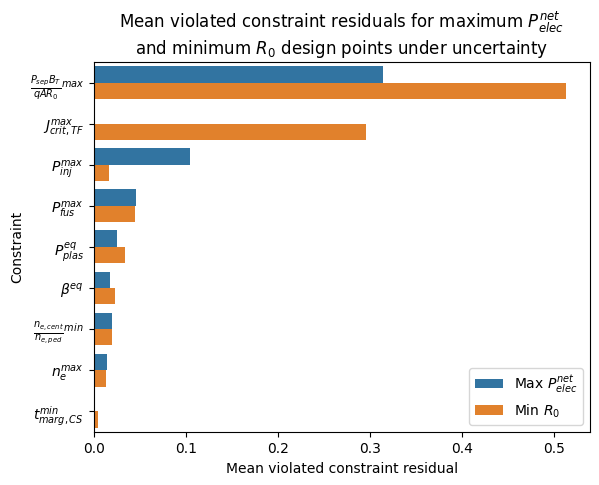

In [5]:
print("Plotting combined violated constraint means.")
# Get absolute values of violated constraint residuals
# Abs values before mean: be fair to eq constraints (either side of 0)
vio_means_series_list = []
for study_name, samples in zip(study_names, samples_list):
    vio_means_series = samples[qois].abs().mean()
    vio_means_series_list.append(vio_means_series)


vio_means_comb = pd.DataFrame(vio_means_series_list, columns=qois, index=study_names)

# Exclude objf and vio-constr_res
filter_qois = ["objf", "vio_constr_res"]
# filter_qois = ["objf"]
vio_means_comb = vio_means_comb[
    vio_means_comb.columns[~vio_means_comb.columns.isin(filter_qois)]
]

vio_means_comb["study"] = vio_means_comb.index
vio_means_comb_melt = vio_means_comb.melt(id_vars="study")
vio_means_comb_melt = vio_means_comb_melt.sort_values("value", ascending=False)
vio_means_comb_melt_gt_0 = vio_means_comb_melt[vio_means_comb_melt["value"] > 2e-3]
vio_means_comb_melt_gt_0

# Plot
fig, ax = plt.subplots()
sns.barplot(
    data=vio_means_comb_melt_gt_0,
    x="value",
    y="variable",
    hue="study",
    hue_order=study_names,
    ax=ax,
)
ax.set_title("Mean violated constraint residuals for maximum $P_{elec}^{net}$\nand minimum $R_0$ design points under uncertainty")
ax.set_xlabel("Mean violated constraint residual")
ax.set_ylabel("Constraint")
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles, labels=["Max $P_{elec}^{net}$", "Min $R_0$"], loc="lower right"
)

constr_labels = {
    "ineq_68": r"$\frac{P_{sep}B_T}{qAR_0}^{max}$",
    "ineq_33": r"$J^{max}_{crit, TF}$",
    "ineq_30": r"$P_{inj}^{max}$",
    "ineq_9": r"$P_{fus}^{max}$",
    "eq_2": r"$P_{plas}^{eq}$", # TODO include balance in symbol? No, ok
    "eq_1": r"$\beta^{eq}$", # TODO understand, better symbol? No ok
    "ineq_81": r"$\frac{n_{e, cent}}{n_{e, ped}}^{min}$",
    "ineq_5": r"$n_{e}^{max}$",
    "ineq_60": r"$t^{min}_{marg, CS}$",
    "ineq_72": r"$\sigma_{Tresca, CS}^{max}$",
    "ineq_34": r"$V^{max}_{quench, TF}$",
}

old_y_label_objs = [y_label_obj for y_label_obj in ax.get_yticklabels()]
new_y_labels = []

for old_y_label_obj in old_y_label_objs:
    old_text = old_y_label_obj.get_text()
    new_text = constr_labels.get(old_text)
    if new_text is None:
        new_text = old_text
    new_y_labels.append(new_text)

ax.set_yticklabels(new_y_labels)
fig.savefig("mean_vio_constr_res.pdf", bbox_inches = 'tight')

### Distribution of violated constraint residuals

Plotting combined distribution of violated constraint residuals.


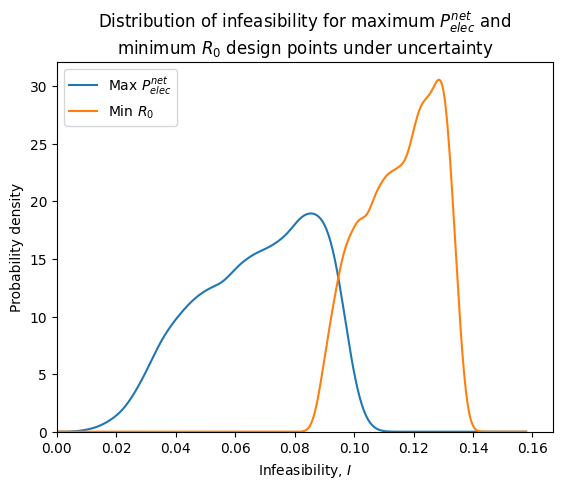

In [41]:
print("Plotting combined distribution of violated constraint residuals.")
vio_constr_series_list = []
results_dict = {}

for campaign, study_name in zip(campaigns, study_names):
    # Analyse a single output variable, vio_constr_res
    results = campaign.analyse(qoi_cols=["vio_constr_res"])
    results_dict[study_name] = results

lower_bound = None
upper_bound = None
for results in results_dict.values():
    # Find bounds of distributions in all results
    dist = results.get_distribution(qoi="vio_constr_res")

    if lower_bound is None:
        lower_bound = dist.lower[0]
    elif dist.lower[0] < lower_bound:
        lower_bound = dist.lower[0]

    if upper_bound is None:
        upper_bound = dist.upper[0]
    elif dist.upper[0] > upper_bound:
        upper_bound = dist.upper[0]

dists_dict = {"study_name": [], "x": [], "pdf": []}
# stats = {}
for study_name, results in results_dict.items():
    # Locations for density function to be evaluated
    # x = np.linspace(dist.lower[0], dist.upper[0], num=500)
    x = np.linspace(lower_bound, upper_bound, num=500)
    dist = results.get_distribution(qoi="vio_constr_res")
    pdf = dist.pdf(x)
    dists_dict["x"].extend(x)
    dists_dict["pdf"].extend(pdf)
    dists_dict["study_name"].extend([study_name for i in range(len(x))])

    # # Get statistical moments
    # stats[study_name] = {"mean": results.raw_data["statistical_moments"]["vio_constr_res"]["mean"]}

vio_res_comb = pd.DataFrame(dists_dict)

# Plot
fig, ax = plt.subplots()

sns.lineplot(data=vio_res_comb, x="x", y="pdf", hue="study_name", ax=ax)

# # Plot mean lines
# for study_name in study_names:
#     plt.vlines(x=stats[study_name]["mean"], ymin=0.0, ymax=25, linestyles="dashed")

ax.set_title(
    "Distribution of infeasibility for maximum $P_{elec}^{net}$ and\nminimum $R_0$ design points under uncertainty"
)
ax.set_xlabel("Infeasibility, $I$")
ax.set_ylabel("Probability density")
ax.set_xlim([0.0, None])
ax.set_ylim([0.0, None])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=["Max $P_{elec}^{net}$", "Min $R_0$"], loc="upper left")
fig.savefig("vio_constr_res_dist.pdf", bbox_inches = 'tight')

### Attempt with Seaborn's KDE only

Plotting combined distribution of violated constraint residuals.


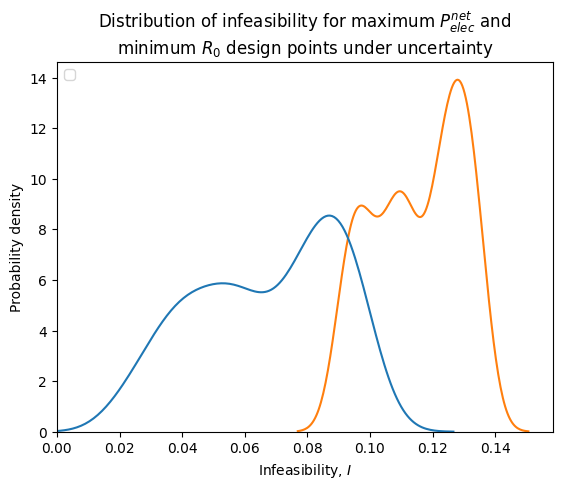

In [34]:
# print("Plotting combined distribution of violated constraint residuals.")
# results_dict = {"study_name": [], "vio_constr_res": []}

# for samples, study_name in zip(samples_list, study_names):
#     vio_constr_res_series = samples["vio_constr_res"].tolist()
#     results_dict["study_name"].extend([study_name] * len(vio_constr_res_series))
#     results_dict["vio_constr_res"].extend(vio_constr_res_series)

# vio_constr_res_df = pd.DataFrame(results_dict)
# vio_constr_res_df
# vio_constr_res_df_melted = vio_constr_res_df.melt(id_vars="study_name")

# # Plot
# fig, ax = plt.subplots()

# # sns.lineplot(data=vio_res_comb, x="x", y="pdf", hue="study_name", ax=ax)
# sns.kdeplot(data=vio_constr_res_df_melted, x="value", hue="study_name", ax=ax)

# ax.set_title(
#     "Distribution of infeasibility for maximum $P_{elec}^{net}$ and\nminimum $R_0$ design points under uncertainty"
# )
# ax.set_xlabel("Infeasibility, $I$")
# ax.set_ylabel("Probability density")
# ax.set_xlim([0.0, None])
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles, labels=["Max $P_{elec}^{net}$", "Min $R_0$"], loc="upper left")
# # fig.savefig("vio_constr_res_dist.pdf", bbox_inches = 'tight')

## Barplot of Sobol indices

Plotting barplot of Sobols for violated constraint residuals.


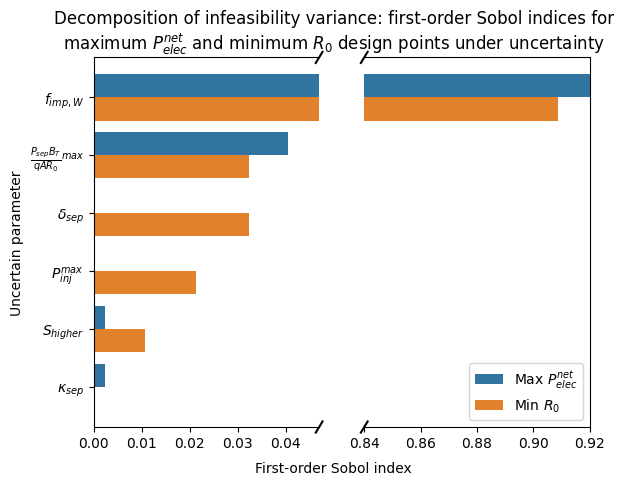

In [7]:
print("Plotting barplot of Sobols for violated constraint residuals.")
# results.sobols_first()
# results.sobols_second()
# TODO Add in total indicies as extra bar

sobols_first_list = []
for study_name, results in results_dict.items():
    sobols_first = results.sobols_first()["vio_constr_res"]
    sobols_total = results.sobols_total()["vio_constr_res"]
    sobols_higher = {}

    # Convert single-valued arrays to floats: pandas doesn't do this with lists for some reason
    for key, value in sobols_first.items():
        sobols_first[key] = value[0]

    for key, value in sobols_total.items():
        sobols_total[key] = value[0]

    # Calculate higher-order Sobol indices
    sobols_higher = 0.0
    for key in sobols_total:
        sobols_higher += sobols_total[key] - sobols_first[key]

    sobols_first["higher_order"] = sobols_higher
    sobols_first["study_name"] = study_name
    sobols_first_list.append(sobols_first)

sobols_first_list
sobols_first_df = pd.DataFrame(sobols_first_list)
sobols_first_df
sobols_first_df_melted = sobols_first_df.melt(id_vars="study_name")
sobols_first_df_melted = sobols_first_df_melted.fillna(0)
sobols_first_df_melted = sobols_first_df_melted.sort_values("value", ascending=False)

# Normal plot
# fig, ax = plt.subplots()
# sns.barplot(
#     data=sobols_first_df_melted, x="value", y="variable", hue="study_name", ax=ax
# )
# ax.set_title("Decomposition of violated constraint residuals variance:\nfirst-order Sobol indices")
# ax.set_xlabel("First-order Sobol index")
# ax.set_ylabel("Uncertain parameter")
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(
#     handles=handles, labels=["Max $P_{elec}^{net}$", "Min $R_0$"], loc="lower right"
# )

# Broken axis plot
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

sns.barplot(
    data=sobols_first_df_melted, x="value", y="variable", hue="study_name", ax=ax1
)
sns.barplot(
    data=sobols_first_df_melted, x="value", y="variable", hue="study_name", ax=ax2
)

# Limit view to different portions of data
ax1.set_xlim(0.0, 0.047)
ax2.set_xlim(0.84, 0.92)
ax1.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax1.yaxis.tick_left()
ax2.tick_params(labelleft=False)
ax2.yaxis.tick_right()

d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

ax2.axes.get_yaxis().set_visible(False)
ax1.set_xlabel("")
ax2.set_xlabel("")
fig.suptitle("Decomposition of infeasibility variance: first-order Sobol indices for\nmaximum $P_{elec}^{net}$ and minimum $R_0$ design points under uncertainty")
fig.supxlabel("First-order Sobol index", fontsize="medium")
ax1.set_ylabel("Uncertain parameter")
handles, labels = ax1.get_legend_handles_labels()
ax2.legend(
    handles=handles, labels=["Max $P_{elec}^{net}$", "Min $R_0$"], loc="lower right"
)
ax1.get_legend().remove()

param_latex = {
    "fdene": r"$f^{max}_{GW}$",
    "hfact": r"$H_{98, y2}$",
    "coreradius": r"$\rho_{core}$",
    "fimp_2": r"$f_{imp, He}$",
    "fimp_14": r"$f_{imp, W}$",
    "psepbqarmax": r"$\frac{P_{sep}B_T}{qAR_0}^{max}$",
    "flhthresh": r"$f^{min}_{LH}$",
    "cboot": r"$c_{BS}$",
    "peakfactrad": r"$\tau^{max}_{rad}$",
    "kappa": r"$\kappa_{sep}$",
    "etaech": r"$n_{ECRH}$",
    "feffcd": r"$f_{CD}$",
    "etath": r"$\eta_{th}$",
    "etaiso": r"$\eta_{iso}$",
    "boundl_18": r"$q^{min}_{95}$",
    "pinjalw": r"$P^{max}_{inj}$",
    "alstroh": r"$\sigma^{max}_{CS}$",
    "sig_tf_wp_max": r"$\simga^{max}_{TF}$",
    "aspect": r"$A$",
    "boundu_2": r"$B^{max}_{T}$",
    "triang": r"$\delta_{sep}$",
    "higher_order": "$S_{higher}$"
}

old_y_label_objs = [y_label_obj for y_label_obj in ax1.get_yticklabels()]
new_y_labels = []

for old_y_label_obj in old_y_label_objs:
    old_text = old_y_label_obj.get_text()
    new_text = param_latex[old_text]
    new_y_labels.append(new_text)

ax1.set_yticklabels(new_y_labels)
fig.savefig("fo_sobols_bar.pdf", bbox_inches = 'tight')